# Project Scoring 3: Ad Click Prediction

The main goal of this project is to create a prediction model to predict whether a user will click on an ad based on the characteristics of the user.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import time
from google.colab import drive

In [3]:
# Get the current location of your notebook
print(os.getcwd())

# Connect to your drive
drive.mount(os.getcwd()+'/drive')

# To navigate and list content of your Drive folders
print(os.listdir('drive/My Drive/00 M2/Scoring'))

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Projet_Scoring3.ipynb', 'advertising.csv']


## Dataset

For this project, I am using a dataset that comes from an anonym marketing agency that contains 10 variables: *Daily Time Spent on Site*, *Age*, *Area Income*, *Daily Internet Usage*, *Ad Topic Line*, *City*, *Gender*, *Country*, *Timestamp*, and *Clicked on Ad*. The variable of interest for this project is the *Clicked on Ad* that takes the value 0 if the user did not click on the add and 1 if they did. The population is 1000 internet users. And the data has been collected between 01/01/2016 and 24/07/2016.

In [4]:
df = pd.read_csv("drive/My Drive/00 M2/Scoring/advertising.csv")

In [5]:
df.dtypes

Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
City                         object
Male                          int64
Country                      object
Timestamp                    object
Clicked on Ad                 int64
dtype: object

Let's change the *Timestamp* variable to a datetime object.

In [6]:
df['Timestamp']=pd.to_datetime(df['Timestamp'])

Now, let's create from this variable new variables to be able to take into account the day of the week and the the of the day for the analysis.

In [7]:
df['Hour']=df['Timestamp'].apply(lambda time : time.hour)
df['DayOfWeek'] = df['Timestamp'].apply(lambda time : time.dayofweek)
df['Month'] = df['Timestamp'].apply(lambda time : time.month)
df['Date'] = df['Timestamp'].apply(lambda t : t.date())

In [8]:
df.head(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Hour,DayOfWeek,Month,Date
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,0,6,3,2016-03-27
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,1,0,4,2016-04-04
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,20,6,3,2016-03-13


In [9]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,Hour,DayOfWeek,Month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000,11.660000,3.064000,3.817000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025,6.960952,1.998474,1.926973
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000,0.000000,0.000000,1.000000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000,6.000000,1.000000,2.000000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000,12.000000,3.000000,4.000000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000,18.000000,5.000000,5.000000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000,23.000000,6.000000,7.000000


## Cleaning

First, let's check for duplicates, missing values and outliers.

In [10]:
df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
Hour                        0
DayOfWeek                   0
Month                       0
Date                        0
dtype: int64

We can see that there are none missing values. That is great!

In [11]:
df.duplicated().sum()

0

In [12]:
df.duplicated(subset=['Age','City', 'Male', 'Country']).sum()

0

There is also no duplicates.

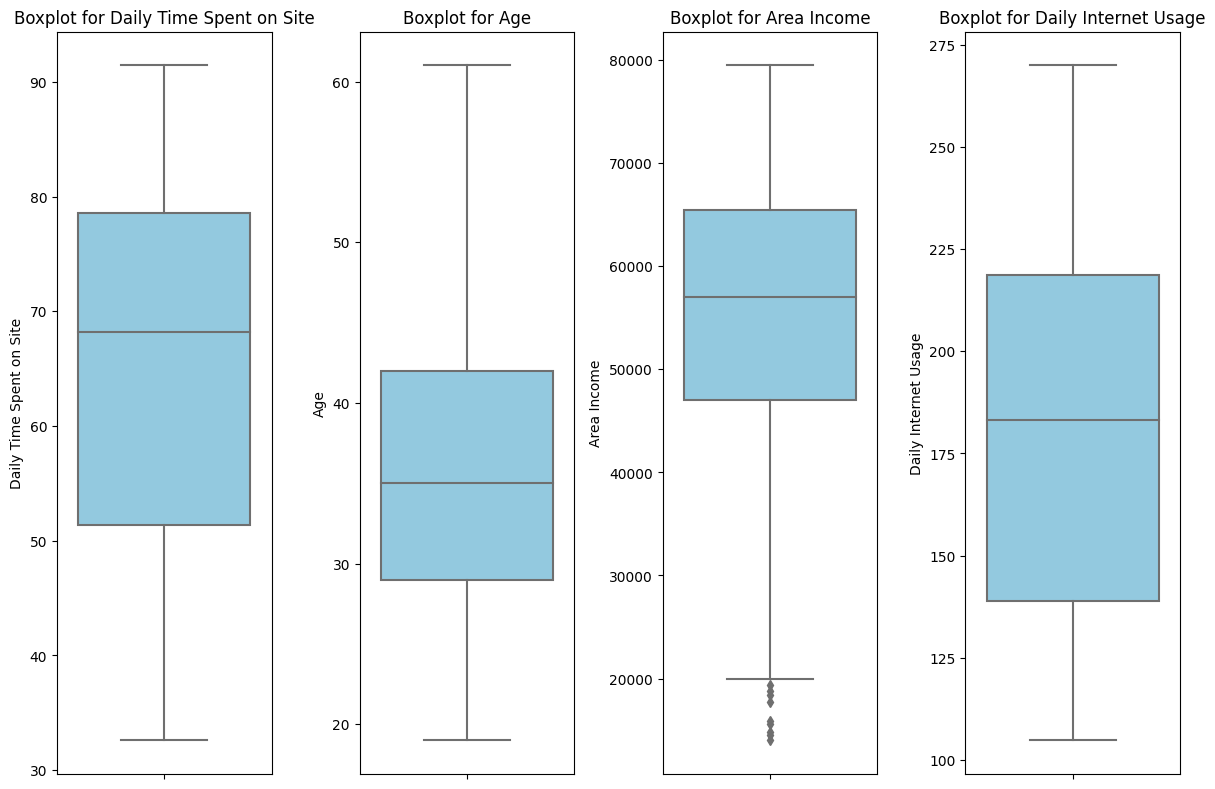

In [13]:
# Get a list of numerical variables
numeric_columns = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

# Create separate vertical boxplots with different scales for each variable
plt.figure(figsize=(12, 8))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)
    sns.boxplot(y=df[column], color='skyblue', orient='v')
    plt.title(f'Boxplot for {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

We can see that there might be some potential outliers for the variable *Area Income* but we can ignore them for the moment.

### Exploratory Data Analysis

In [14]:
df.dtypes

Daily Time Spent on Site           float64
Age                                  int64
Area Income                        float64
Daily Internet Usage               float64
Ad Topic Line                       object
City                                object
Male                                 int64
Country                             object
Timestamp                   datetime64[ns]
Clicked on Ad                        int64
Hour                                 int64
DayOfWeek                            int64
Month                                int64
Date                                object
dtype: object

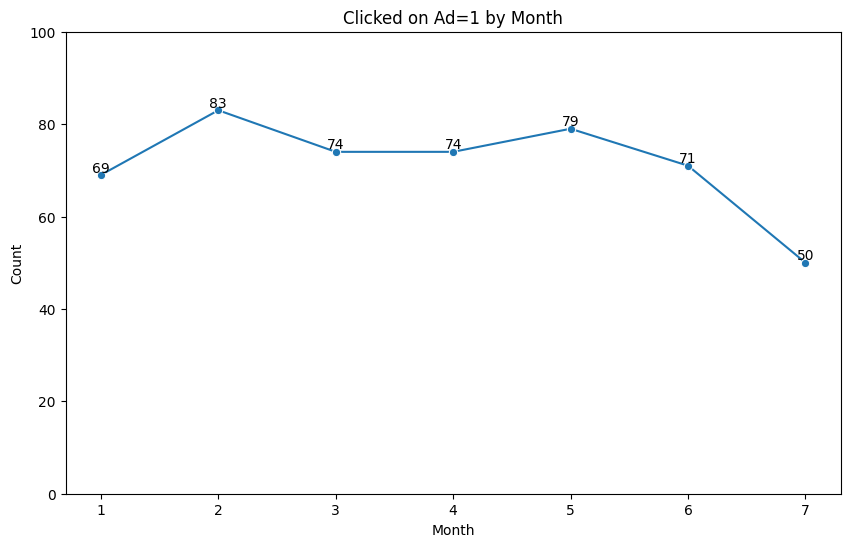

In [15]:
clicked_by_month = df[df['Clicked on Ad'] == 1].groupby('Month')['Clicked on Ad'].sum()

plt.figure(figsize=(10, 6))
sns.lineplot(x=clicked_by_month.index, y=clicked_by_month.values, marker='o')
plt.title('Clicked on Ad=1 by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ylim(0, 100)

for i, count in enumerate(clicked_by_month.values):
    plt.text(clicked_by_month.index[i], count, str(count), ha='center', va='bottom') # Add labels to data points

plt.show()

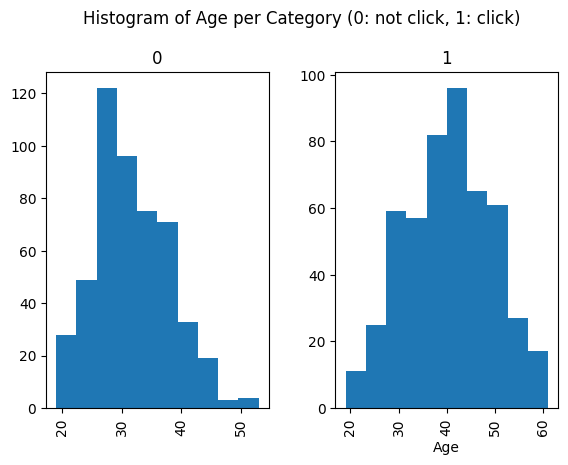

In [16]:
df.hist('Age', by='Clicked on Ad')
plt.suptitle('Histogram of Age per Category (0: not click, 1: click)')
plt.xlabel('Age')
plt.subplots_adjust(top=0.85)
plt.show()

We can see that among the users that clicked, the most contibutors are the ones around 40. Among the users that did not click, the most contributors are around 30 years old.

Text(0.5, 1.0, 'Ad clicked distribution per gender')

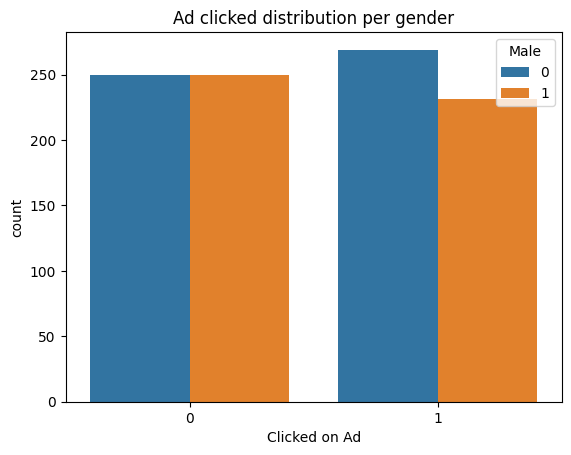

In [17]:
sns.countplot(x='Clicked on Ad',data=df,hue='Male')
plt.title('Ad clicked distribution per gender')

We can see that among the users that clicked on the ad, there are more females than males.

Text(0.5, 1.0, 'Ad clicked distribution per day of the week')

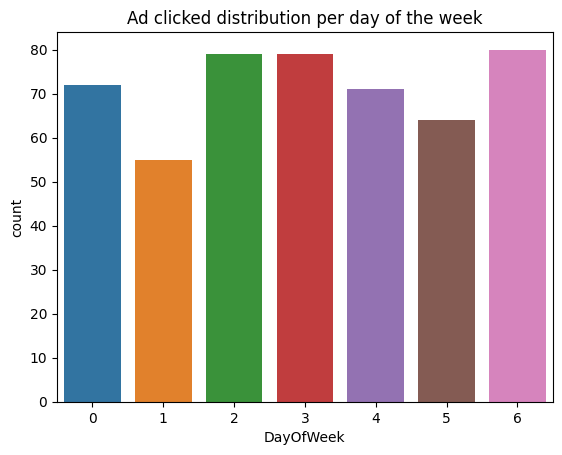

In [18]:
sns.countplot(x='DayOfWeek',data=df[df['Clicked on Ad']==1])
plt.title('Ad clicked distribution per day of the week')

Text(0.5, 1.0, 'Ad clicked distribution per day of the week by gender')

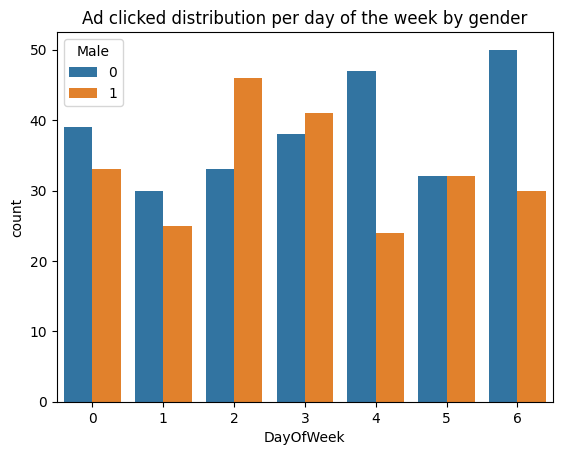

In [19]:
sns.countplot(x='DayOfWeek',data=df[df['Clicked on Ad']==1],hue='Male')
plt.title('Ad clicked distribution per day of the week by gender')

We can see that the day in which people click the most is Sunday, and the days in which people click the least is Tuesday. We can see that in general, females tend to click more than male all days of the weeks expect for wednesday and thursday.

Text(0.5, 1.0, 'Ad clicked hourly distribution')

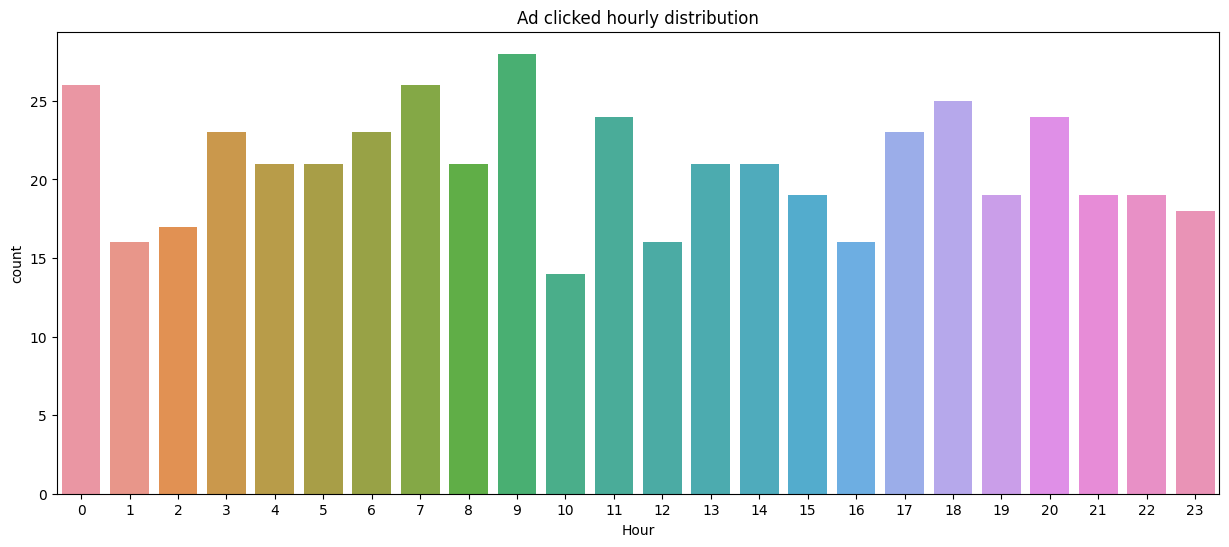

In [20]:
plt.figure(figsize=(15,6))
sns.countplot(x='Hour',data=df[df['Clicked on Ad']==1])
plt.title('Ad clicked hourly distribution')

We can see that people click the most at 9 am and the least at 10 am. But here, we would need to take into account the time difference between the different countries. Thus, we should transform this variable but since we don't know what is the time zone for the *Timestamp*, and that the users are in different countries, we sadly cannot do anything with this variables.

In [21]:
df['Ad Topic Line'].nunique()


1000

We also notice that all ad topics are different. Thus we cannot add it to our future model. We can also drop this variable.

<ipython-input-22-998818bda9f2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  s = sns.heatmap(df.corr(),


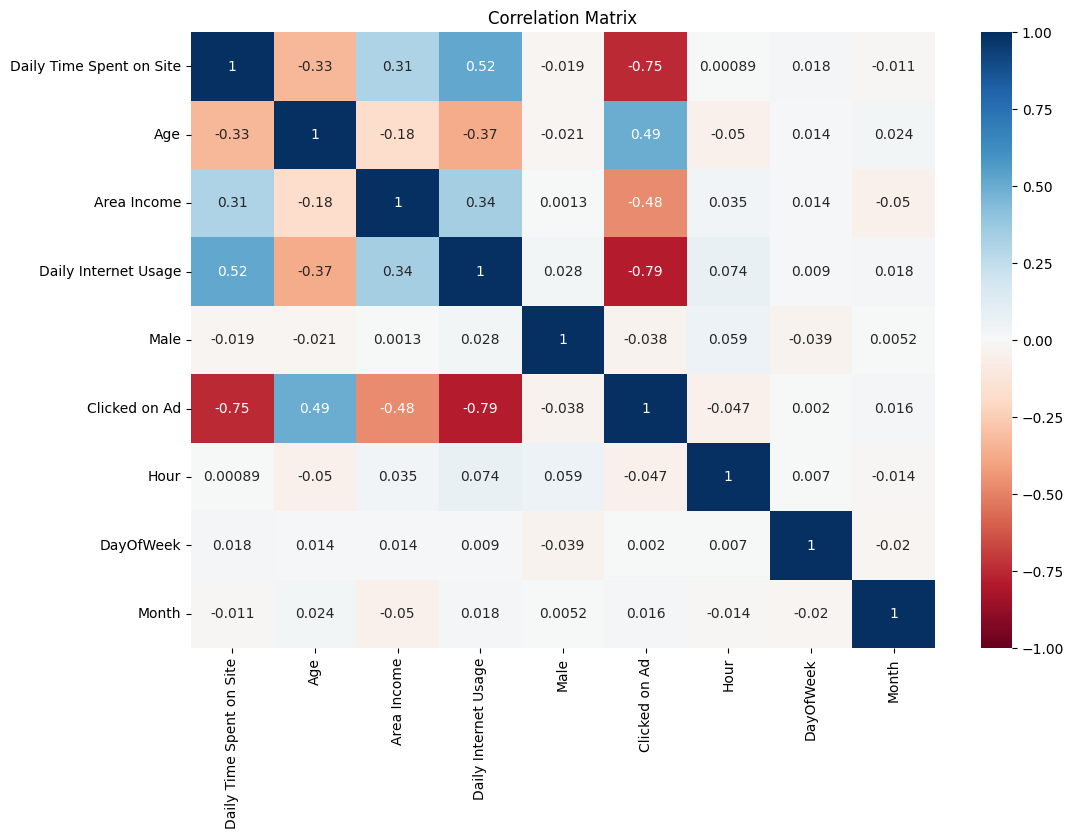

In [22]:
plt.figure(figsize=(12, 8))
s = sns.heatmap(df.corr(),
                annot=True,
                cmap='RdBu',
                vmin=-1,
                vmax=1)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.title('Correlation Matrix')
plt.show()

On this heatmap, we can see the correlation value between all the variables in the dataset. We can see that the more time you spend daily on the website, the less likely you are to click on the ad. Similarly, the more time you use the internet daily, the less likely you are to click on the ad. In addition, the likeliness of clicking increases with age and decreases when the area income increase.

## Data preparation

We can delete the variables that we won't use for the different Scoring models.

In [23]:
df['Country'].nunique()

237

Here we can see that there are to many countries for this variable to be relevant. We can thus delete it. However, if we did not want to delete it, we should transform it as dummies.

In [24]:
country= pd.get_dummies(df['Country'],drop_first=True)

Then, we can delete the variables that we won't use for the different Scoring models.

In [25]:
df.drop(['Timestamp', 'City', 'Country', 'Ad Topic Line', 'Hour', 'Date'], axis = 1, inplace = True)

Now let's split the dataset in training ans testing sets.

In [26]:
X= df.drop('Clicked on Ad',axis=1)
y= df['Clicked on Ad']

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

First, let's do a Logistic Regression with the default parameters.

In [29]:
logmodel_default= LogisticRegression()
logmodel_default.fit(X_train,y_train)
y_pred_logmodel_default = logmodel_default.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred_logmodel_default))
print(confusion_matrix(y_test, y_pred_logmodel_default))
print(accuracy_score(y_test,y_pred_logmodel_default))
lg=accuracy_score(y_test,y_pred_logmodel_default)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       105
           1       0.93      0.88      0.91        95

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200

[[99  6]
 [11 84]]
0.915


The accuracy is already very good, but let's see if we can make it better by changing some parameters.

In [31]:
logmodel_lib= LogisticRegression(solver='liblinear', penalty='l1')
logmodel_lib.fit(X_train,y_train)
y_pred_logmodel_lib = logmodel_lib.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred_logmodel_lib))
print(confusion_matrix(y_test, y_pred_logmodel_lib))
print(accuracy_score(y_test,y_pred_logmodel_lib))
lg=accuracy_score(y_test,y_pred_logmodel_lib)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       105
           1       0.99      0.96      0.97        95

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

[[104   1]
 [  4  91]]
0.975


Here the accuracy is even better! Let's try to use GridSearch to find the best parameters for the solver liblinear.

In [33]:
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(solver='liblinear')

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

log_best_model = grid_search.best_estimator_
y_pred_logbest = log_best_model.predict(X_test)

print(classification_report(y_test, y_pred_logbest))
print(confusion_matrix(y_test, y_pred_logbest))
print(accuracy_score(y_test,y_pred_logbest))
lg=accuracy_score(y_test,y_pred_logbest)

Best Hyperparameters: {'C': 1000, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       105
           1       0.99      0.96      0.97        95

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

[[104   1]
 [  4  91]]
0.975


Remark: Here we don't need to do a features selection since we use a penalty l1. Indeed,  l1 penalty (Lasso regularization) automatically performs a form of feature selection by encouraging sparsity in the coefficients. The L1 penalty adds the sum of the absolute values of the coefficients to the logistic regression objective function. And, as a result, some coefficients may become exactly zero, effectively excluding the corresponding features from the model.

Let's look at the odds ratios.

In [34]:
log_odds = log_best_model.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)

,coef
DayOfWeek,0.143817
Age,0.141713
Month,0.109447
Area Income,-0.000127
Daily Internet Usage,-0.061867
Daily Time Spent on Site,-0.180658
Male,-0.442551


Interpretation:

For female users, the odds of clicking are 0.44 times as larges as the odds for not clicking (when all other variables are held constant).

As the user age increases by one, the odds for clicking are 0.14 as large as the odds for not clicking (when all other variables are held constant).

Now, let's plot the ROC Curve and AUC for the best logistic regression model.

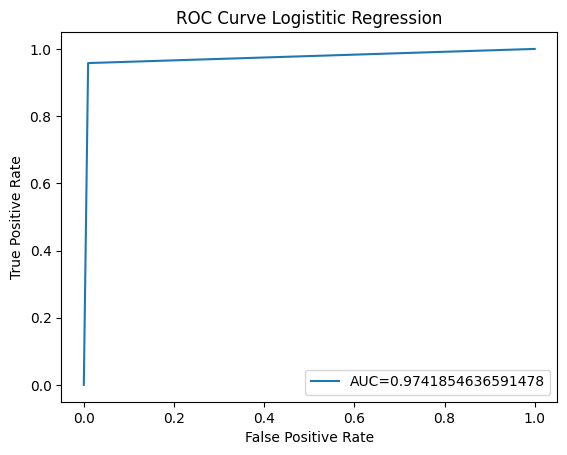

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_logbest)
auc_log = roc_auc_score(y_test, y_pred_logbest)
plt.plot(fpr_log,tpr_log,label="AUC="+str(auc_log))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve Logistitic Regression')
plt.show()

## Random Forest

First let's do a Random Forest with the default parameters.

In [42]:
from sklearn.ensemble import RandomForestClassifier

randomforest= RandomForestClassifier()
randomforest.fit(X_train,y_train)
y_pred_randomforest_default= randomforest.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred_randomforest_default))
print(confusion_matrix(y_test, y_pred_randomforest_default))
print(accuracy_score(y_test,y_pred_randomforest_default))
rf_default=accuracy_score(y_test,y_pred_randomforest_default)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       105
           1       0.97      0.95      0.96        95

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200

[[102   3]
 [  5  90]]
0.96


Here the accuracy is already very good. Let's try to use GridSearch to find the best parameters.

In [38]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20]
}

grid_search = GridSearchCV(estimator=randomforest, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

randomforest_best_model = grid_search.best_estimator_
y_pred_randomforest_best_model = randomforest_best_model.predict(X_test)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}


In [39]:
print(classification_report(y_test, y_pred_randomforest_best_model))
print(confusion_matrix(y_test, y_pred_randomforest_best_model))
print(accuracy_score(y_test,y_pred_randomforest_best_model))
rf=accuracy_score(y_test,y_pred_randomforest_best_model)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       105
           1       0.96      0.96      0.96        95

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200

[[101   4]
 [  4  91]]
0.96


We see that we obtain the same accuracy as with the default parameters.

Remark: Here, we do not do feature selection since Random Forest models have built-in feature selection mechanisms due to the nature of the algorithm. Indeed, Random Forests calculate feature importance based on how much each feature contributes to reducing impurity (e.g., Gini impurity) across all decision trees in the forest. And thus, features with low importance can be implicitly considered less influential and may have less impact on the final predictions.

Now, let's plot the ROC Curve and AUC for the best random forest classifier model.

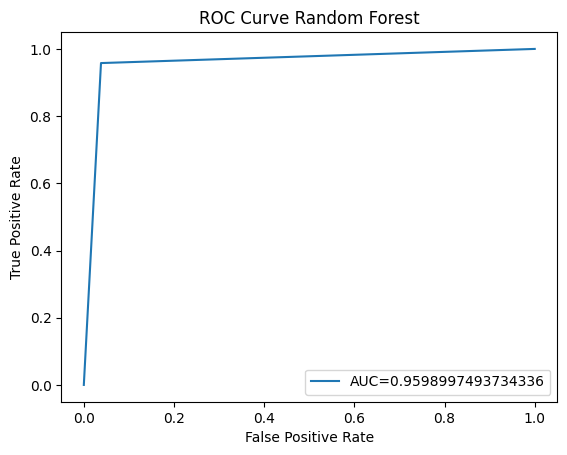

In [49]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_randomforest_best_model)
auc_rf = roc_auc_score(y_test, y_pred_randomforest_best_model)
plt.plot(fpr_rf,tpr_rf,label="AUC="+str(auc_rf))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve Random Forest')
plt.show()

## XGBoost

First let's do an XGBoost with the default parameters.

In [45]:
from xgboost import XGBClassifier

xgb_default = XGBClassifier()
xgb_default.fit(X_train,y_train)
y_pred_xgb_default = xgb_default.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred_xgb_default))
print(confusion_matrix(y_test, y_pred_xgb_default))
print(accuracy_score(y_test,y_pred_xgb_default))
xgbs=accuracy_score(y_test,y_pred_xgb_default)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       105
           1       0.96      0.94      0.95        95

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

[[101   4]
 [  6  89]]
0.95


Here the accuracy is already very good. Let's try to use GridSearch to find the best parameters.

In [47]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_default, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

xgbs_best_model = grid_search.best_estimator_
y_pred_xgbs_best_model = xgbs_best_model.predict(X_test)

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}


In [50]:
print(classification_report(y_test, y_pred_xgbs_best_model))
print(confusion_matrix(y_test, y_pred_xgbs_best_model))
print(accuracy_score(y_test,y_pred_xgbs_best_model))
xgbs=accuracy_score(y_test,y_pred_xgbs_best_model)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       105
           1       0.97      0.94      0.95        95

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200

[[102   3]
 [  6  89]]
0.955


We see that we obtain an accuracy slitghly higher than with the default parameters.

Remark: Here, we do not do feature selection since XGBoost has a built-in feature selection mechanism through the importance scores assigned to each feature during training as it is a tree-based ensemble algorithm.

Now, let's plot the ROC Curve and AUC for the best XGBoost model.

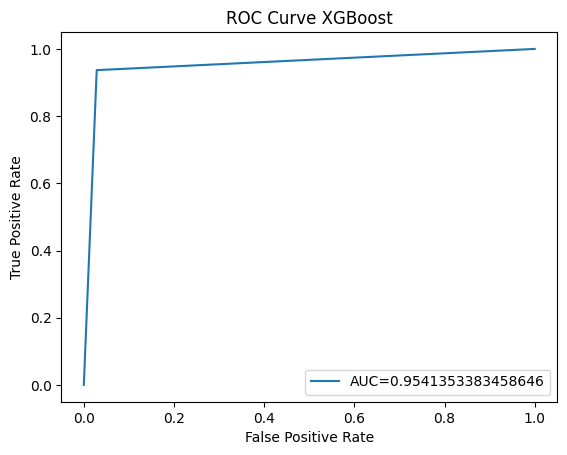

In [51]:
fpr_xgbs, tpr_xgbs, _ = roc_curve(y_test, y_pred_xgbs_best_model)
auc_xgbs = roc_auc_score(y_test, y_pred_xgbs_best_model)
plt.plot(fpr_xgbs,tpr_xgbs,label="AUC="+str(auc_xgbs))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve XGBoost')
plt.show()

## Model comparison

First, let's compare the three models using the accuracy score.

In [57]:
pd.DataFrame({
    'Model':['Logistic Regression','Random Forest', 'XGBoost'],
    'Accuracy_score' :[lg,rf, xgbs]
})

,Model,Accuracy_score
0,Logistic Regression,0.975
1,Random Forest,0.960
2,XGBoost,0.955


Now, let's compare the ROC Curves and AUC.

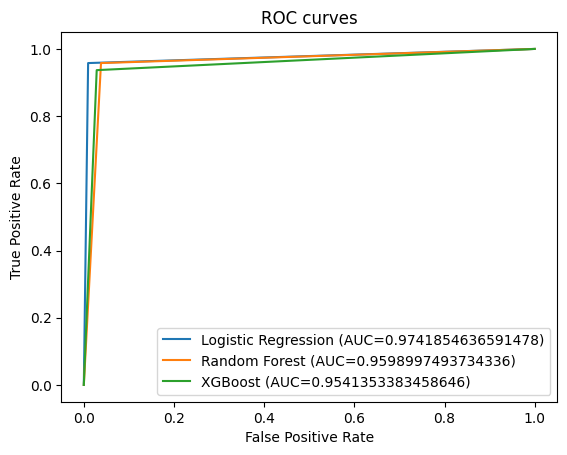

In [56]:
# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_logbest)
auc_log = roc_auc_score(y_test, y_pred_logbest)
plt.plot(fpr_log, tpr_log, label="Logistic Regression (AUC=" + str(auc_log) + ")")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_randomforest_best_model)
auc_rf = roc_auc_score(y_test, y_pred_randomforest_best_model)
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC=" + str(auc_rf) + ")")

# XGBoost
fpr_xgbs, tpr_xgbs, _ = roc_curve(y_test, y_pred_xgbs_best_model)
auc_xgbs = roc_auc_score(y_test, y_pred_xgbs_best_model)
plt.plot(fpr_xgbs, tpr_xgbs, label="XGBoost (AUC=" + str(auc_xgbs) + ")")

# Plot
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curves')
plt.show()

To sum up, we can see that according to both evaluation metrics, the best model for this dataset is the logistic regression with {solver:'liblinear', 'C': 100, 'penalty': 'l1'}.